In [125]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import torch
import torch.nn.functional as F
from transformers import AutoModelForCausalLM, AutoTokenizer

import matplotlib.pyplot as plt
import seaborn as sns

# Qwen 2.5 & Process Attention Scores

In [ ]:
"""
Wrapper for Qwen model
"""

class QwenModel:
    def __init__(self, model_name="Qwen/Qwen2.5-1.5B-Instruct"):
        
        self.model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.bfloat16, device_map="auto")
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)

        self.prompt = "Please answer this question directly with the least number of words. "

    def get_text_response(self, query):
        messages = [
            {"role": "system", "content": "You are Qwen, created by Alibaba Cloud. You are a helpful assistant."},
            {"role": "user", "content": self.prompt + query}
        ]
        text = self.tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
        model_inputs = self.tokenizer([text], return_tensors="pt").to(self.model.device)

        # Generate the text response
        outputs = self.model.generate(**model_inputs, max_new_tokens=32, return_dict_in_generate=True)
        generated_ids = outputs.sequences
        text_response = self.tokenizer.batch_decode(generated_ids[:, model_inputs.input_ids.shape[-1]:], skip_special_tokens=True)[0]
        return text_response
    
    def get_full_response(self, query):
        messages = [
            {"role": "system", "content": "You are Qwen, created by Alibaba Cloud. You are a helpful assistant."},
            {"role": "user", "content": self.prompt + query}
        ]
        text = self.tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
        model_inputs = self.tokenizer([text], return_tensors="pt").to(self.model.device)

        # Generate response with attention scores
        outputs = self.model.generate(**model_inputs, max_new_tokens=32, output_attentions=True, return_dict_in_generate=True)
        generated_ids = outputs.sequences
        text_response = self.tokenizer.batch_decode(generated_ids[:, model_inputs.input_ids.shape[-1]:], skip_special_tokens=False)[0]
        return model_inputs.input_ids, outputs.attentions, generated_ids, text_response 

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-1.5B-Instruct")
qwen = QwenModel()

In [ ]:
""" Understand the shape of the returned attetntion scores ....

attentions = outputs.attentions # attentions is a tuple

print(len(attentions)) # length = number of newly generated tokens (including <eos> token); each element of the tuple corresponds to a newly generated token

print(len(attentions[0])) # each element of attentions is again a tuple of 28 elements corresponding to 28 layers

print(attentions[0][0].shape) # [1, 12 attention heads, 1, current token length]


"""
def get_layerwise_attention_scores(answer_token_indexes, attentions):

    max_seq_len = attentions[answer_token_indexes[-1]][0][0].shape[-1] # token len of the very final answer token, used to pad attention scores of previous tokens

    layerwise_attn_score = []

    for idx in answer_token_indexes:
        attn_scores = attentions[idx]
        num_layers = len(attn_scores)

        per_ans_token_layerwise_attn_score = []
        for l in range(num_layers):
            
            scores = attn_scores[l][0, :, -1, :]  # [1, num_heads, 1, current_token_len] --> [num_heads, current_token_len]

            # Pad scores to max_seq_len
            if scores.size(-1) < max_seq_len:
                scores = F.pad(scores, (0, max_seq_len - scores.size(-1)), "constant", 0)

            scores = scores.mean(0)  # take average (or sum if needed) over the attention heads
            per_ans_token_layerwise_attn_score.append(scores)

        per_ans_token_layerwise_attn_score = torch.stack(per_ans_token_layerwise_attn_score, dim=0) # tensor shape = [num_layers, max_seq_len]
        layerwise_attn_score.append(per_ans_token_layerwise_attn_score)
    
    # Stack and take the SUM over all answer tokens
    layerwise_attn_score = torch.stack(layerwise_attn_score, dim=0).sum(0).squeeze() # tensor shape = [num_layers, max_seq_len]
    layerwise_attn_score = layerwise_attn_score.to(torch.float32)  # Convert to float32 for compatibility
    return layerwise_attn_score

# Chat & Visualize

In [ ]:
""" STEP 1 : Query the model """

input_ids, attentions, generated_ids, text_response = qwen.get_full_response("Who is the president of China?")

print(input_ids.shape, generated_ids.shape)
print(input_ids)
print(generated_ids)

print("\n", tokenizer.batch_decode(generated_ids[:,:], skip_special_tokens=False)[0])

torch.Size([1, 48]) torch.Size([1, 51])
tensor([[151644,   8948,    198,   2610,    525,   1207,  16948,     11,   3465,
            553,  54364,  14817,     13,   1446,    525,    264,  10950,  17847,
             13, 151645,    198, 151644,    872,    198,   5501,   4226,    419,
           3405,   5961,    448,    279,   3245,   1372,    315,   4244,     13,
          10479,    374,    279,   4767,    315,   5616,     30, 151645,    198,
         151644,  77091,    198]], device='cuda:0')
tensor([[151644,   8948,    198,   2610,    525,   1207,  16948,     11,   3465,
            553,  54364,  14817,     13,   1446,    525,    264,  10950,  17847,
             13, 151645,    198, 151644,    872,    198,   5501,   4226,    419,
           3405,   5961,    448,    279,   3245,   1372,    315,   4244,     13,
          10479,    374,    279,   4767,    315,   5616,     30, 151645,    198,
         151644,  77091,    198,  70630,  93386, 151645]], device='cuda:0')

 <|im_start|>system
Y

In [ ]:
""" STEP 2 : Now copy/paste the keywords within the generated answer (sometimes you may need to copy the blank spaces as well) """

constraint_text = "Xi Jinping"
constraint_ids = tokenizer([constraint_text], return_tensors="pt").input_ids[0]
gen_ids = generated_ids[0].detach().cpu()
# print(gen_ids, constraint_ids)

## find the index of the answer token ids (starting from right to left) with respect to the generated ids
answer_token_indexes = [torch.where(gen_ids == ids)[0].item() for ids in constraint_ids]
answer_token_indexes = [x - generated_ids.shape[1] for x in answer_token_indexes]
print(answer_token_indexes)
# print(tokenizer.batch_decode(generated_ids[:,answer_token_indexes[0]:answer_token_indexes[-1]+1], skip_special_tokens=False)[0])

# ATTENTION SCORES
layerwise_attn_score = get_layerwise_attention_scores(answer_token_indexes=answer_token_indexes, attentions=attentions)
print(layerwise_attn_score.shape)

[-3, -2]
torch.Size([28, 49])


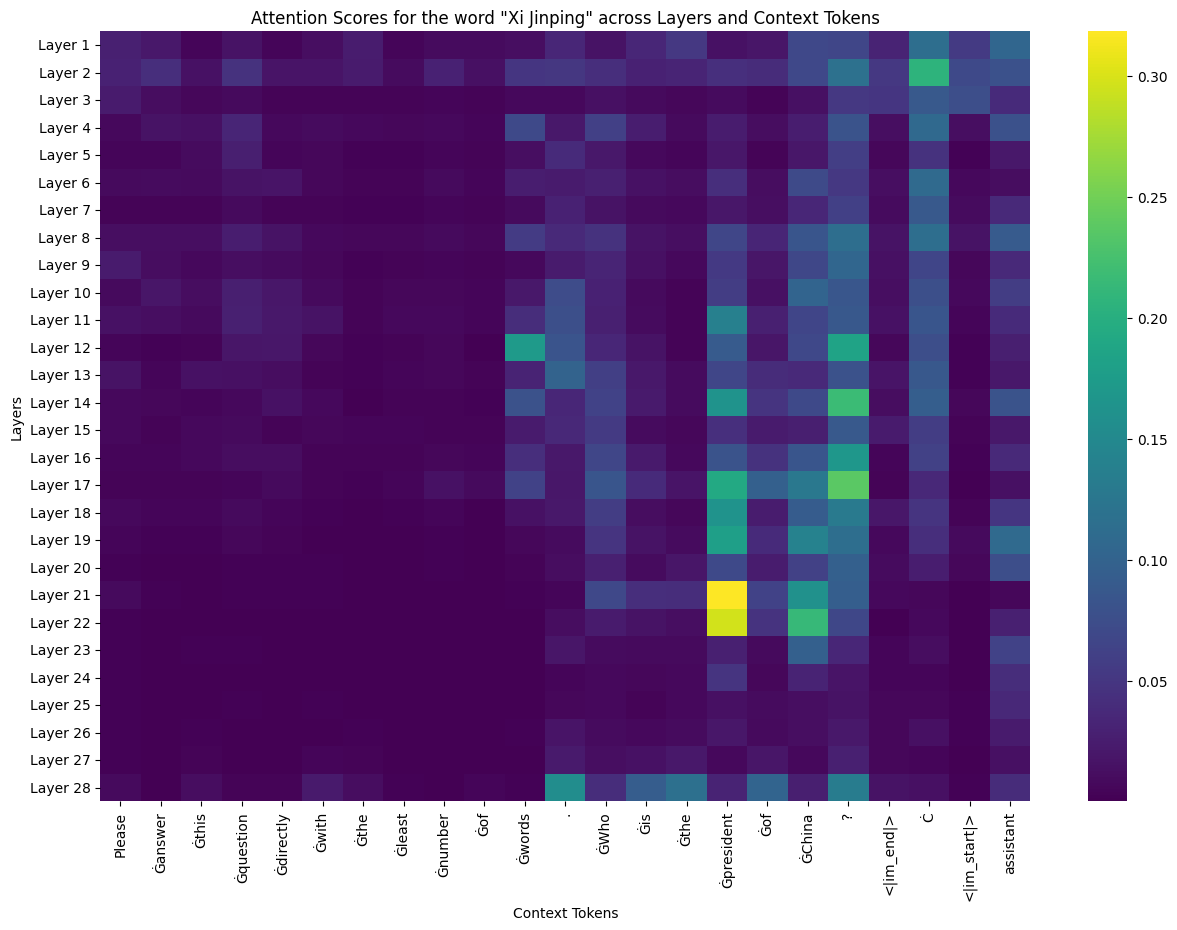

In [ ]:
""" STEP 3 : Visualize attention scores """

# the context we want to visualize starts from the word "Please" (token index of 24; might differ for another model) to the very first answer token
answer_length = layerwise_attn_score.shape[-1] - len(answer_token_indexes)

# Decode the context tokens for display
context_tokens = tokenizer.convert_ids_to_tokens(input_ids[0, 24:answer_length])

# Create a heatmap for the attention scores
plt.figure(figsize=(15, 10))
sns.heatmap(layerwise_attn_score[:, 24:answer_length].detach().cpu().numpy(), xticklabels=context_tokens, yticklabels=[f'Layer {i+1}' for i in range(layerwise_attn_score.shape[0])], cmap='viridis')

# Add labels and title
plt.xlabel('Context Tokens')
plt.ylabel('Layers')
plt.title(f'Attention Scores for the word "{constraint_text}" across Layers and Context Tokens')
plt.xticks(rotation=90)
plt.yticks(rotation=0)

# Display the heatmap
plt.show()